# Handling Class Imbalance

**Purpose**: Address the severe class imbalance problem discovered in EDA.

**Problem Summary** (from EDA):
- Forward: 74.2% (7,343 samples) - dominant class
- Left: 16.4% (1,620 samples)
- Right: 9.5% (937 samples) - severe minority
- **Imbalance ratio**: 7.8:1 (Forward:Right)

**Why this matters**: 
- Models will bias toward predicting "Forward" to minimize training error
- Minority classes (especially Right) will be poorly predicted
- Overall accuracy can be high while minority class accuracy is terrible

**Goal**: Create balanced training sets using multiple strategies, compare them, save for use in modeling notebooks.

## 1. Setup and Load Data

In [19]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# For class imbalance handling
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Settings
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [20]:
# Load temporal splits (created in EDA)
# We only balance TRAINING set, validation and test remain unchanged!
data = np.load('../data/splits_temporal.npz')

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

print("Loaded temporal splits:")
print(f"Train: {len(X_train)} samples")
print(f"Val:   {len(X_val)} samples")
print(f"Test:  {len(X_test)} samples")

# Label names for visualization
label_names = {-1: 'Left', 0: 'Forward', 1: 'Right'}

Loaded temporal splits:
Train: 5940 samples
Val:   1980 samples
Test:  1980 samples


## 2. Review Original Imbalance

Let's visualize the class distribution in our training set to see the problem clearly.

In [21]:
# Count classes in training set
train_counts = Counter(y_train)

print("Training Set Distribution:")
print("-" * 50)
for label in [-1, 0, 1]:
    count = train_counts[label]
    percentage = (count / len(y_train)) * 100
    print(f"{label_names[label]:8s}: {count:5d} samples ({percentage:5.1f}%)")
print("-" * 50)

# Calculate imbalance ratios
forward_to_left = train_counts[0] / train_counts[-1]
forward_to_right = train_counts[0] / train_counts[1]
print(f"\nImbalance ratios:")
print(f"  Forward:Left  = {forward_to_left:.1f}:1")
print(f"  Forward:Right = {forward_to_right:.1f}:1  ← Severe!")

Training Set Distribution:
--------------------------------------------------
Left    :  1033 samples ( 17.4%)
Forward :  4252 samples ( 71.6%)
Right   :   655 samples ( 11.0%)
--------------------------------------------------

Imbalance ratios:
  Forward:Left  = 4.1:1
  Forward:Right = 6.5:1  ← Severe!


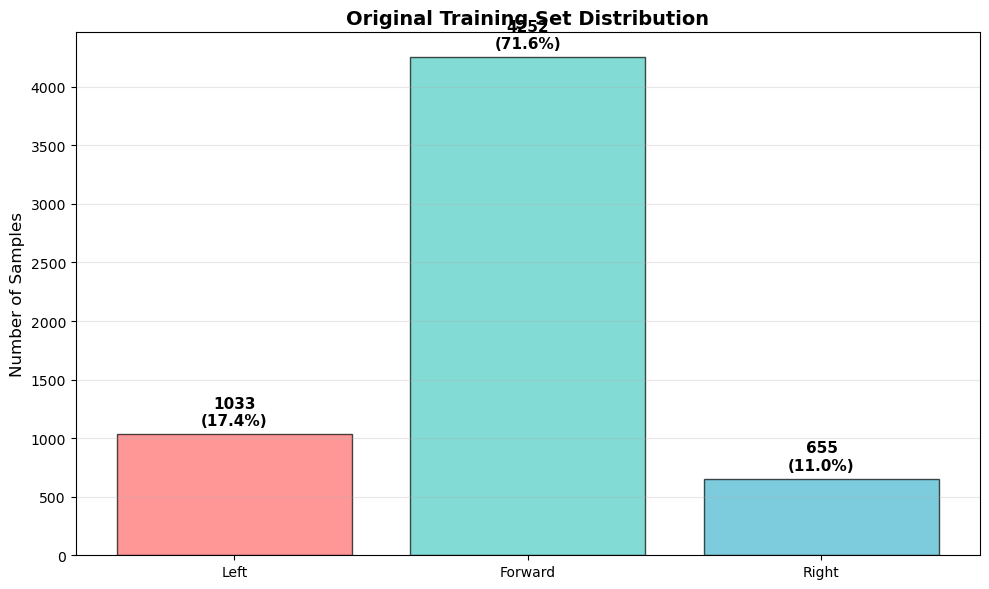


⚠️ Problem: Right class has only 655 samples, while Forward has 4253!
Models trained on this will likely ignore Right turns.


In [22]:
# Visualize original distribution
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Left', 'Forward', 'Right']
counts = [train_counts[-1], train_counts[0], train_counts[1]]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Original Training Set Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{count}\n({count/len(y_train)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Problem: Right class has only 655 samples, while Forward has 4253!")
print("Models trained on this will likely ignore Right turns.")

## 3. Method 1: Class Weights

**How it works**: 
- Don't change the dataset
- Instead, change the loss function to penalize mistakes on minority classes more
- Formula: `weight[class] = n_samples / (n_classes × n_samples_in_class)`

**Advantages**:
- Simple and fast
- No synthetic data created
- Works with any model that supports weighted loss

**Disadvantages**:
- Doesn't increase training data for minority classes
- Model still sees fewer minority examples

In [23]:
# Compute class weights using sklearn
# This computes: total_samples / (n_classes × samples_per_class)
classes = np.unique(y_train)
weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

print("Computed Class Weights:")
print("-" * 40)
for label, weight in zip(classes, weights_array):
    print(f"{label_names[label]:8s} (label={label:2d}): {weight:.3f}")
print("-" * 40)

print("\nInterpretation:")
print(f"- Right class has weight {weights_array[np.where(classes == 1)[0][0]]:.2f} (highest)")
print(f"- Forward class has weight {weights_array[np.where(classes == 0)[0][0]]:.2f} (lowest)")
print("→ Mistakes on Right turns will be penalized ~7× more than Forward!")

Computed Class Weights:
----------------------------------------
Left     (label=-1): 1.917
Forward  (label= 0): 0.466
Right    (label= 1): 3.023
----------------------------------------

Interpretation:
- Right class has weight 3.02 (highest)
- Forward class has weight 0.47 (lowest)
→ Mistakes on Right turns will be penalized ~7× more than Forward!


In [24]:
# Create weight dictionary for Keras/TensorFlow
# Keras expects labels mapped to 0, 1, 2 (not -1, 0, 1)
# So we map: -1→0, 0→1, 1→2
class_weights_dict = {}
for i, label in enumerate([-1, 0, 1]):
    class_weights_dict[i] = weights_array[np.where(classes == label)[0][0]]

print("\nClass weights dictionary (for Keras):")
print(class_weights_dict)
print("\nUsage in Keras:")
print("  model.fit(X, y, class_weight=class_weights_dict, ...)")

# Save for use in modeling notebooks
np.save('../data/class_weights.npy', class_weights_dict)
print("\n✅ Saved to: data/class_weights.npy")


Class weights dictionary (for Keras):
{0: 1.9167473378509197, 1: 0.4656632173095014, 2: 3.0229007633587788}

Usage in Keras:
  model.fit(X, y, class_weight=class_weights_dict, ...)

✅ Saved to: data/class_weights.npy


## 4. Method 2: Temporal Frame Interpolation (TFI)

**How it works**:
- Find consecutive frames of minority classes (e.g., frame 500, 501 both labeled "Right")
- Create intermediate frames by interpolating between them
- Formula: `new_frame = (1-α) × frame_t + α × frame_t+1` where α ∈ (0, 1)
- Label interpolated frames with the same label as originals

**Why this is MUCH better than SMOTE for temporal image data**:
- ✅ Preserves temporal coherence (only interpolates consecutive frames)
- ✅ Creates realistic intermediate vehicle positions
- ✅ Generated frames represent plausible states along the trajectory
- ✅ Labels remain valid (vehicle is still turning in the same direction)

**Contrast with SMOTE**:
- ❌ SMOTE mixes random frames from anywhere in the dataset (e.g., frame 50 + frame 800)
- ❌ Creates blurry, unrealistic images that don't represent any real vehicle state
- ❌ Breaks temporal structure of sequential data

**Analogy**: Like video frame rate conversion (24fps → 60fps) - we're creating smooth intermediate frames.

In [25]:
# Find consecutive minority class frames
# We'll focus on Right class (most severe minority)

minority_class = 1  # Right turns
minority_indices = np.where(y_train == minority_class)[0]

print(f"Right turn frames: {len(minority_indices)} total")
print(f"First few indices: {minority_indices[:10]}")

# Find consecutive pairs (frame_t, frame_t+1 both labeled Right)
consecutive_pairs = []
for i in range(len(minority_indices) - 1):
    idx1 = minority_indices[i]
    idx2 = minority_indices[i + 1]
    if idx2 - idx1 == 1:  # Consecutive in original sequence
        consecutive_pairs.append((idx1, idx2))

print(f"\nFound {len(consecutive_pairs)} consecutive Right turn frame pairs")
print(f"Example pairs: {consecutive_pairs[:5]}")

print("\n💡 These pairs represent smooth Right turn sequences.")
print("We can safely interpolate between them to create realistic intermediate frames.")

Right turn frames: 655 total
First few indices: [ 52 206 230 231 235 236 237 242 243 267]

Found 342 consecutive Right turn frame pairs
Example pairs: [(230, 231), (235, 236), (236, 237), (242, 243), (267, 268)]

💡 These pairs represent smooth Right turn sequences.
We can safely interpolate between them to create realistic intermediate frames.


In [26]:
def temporal_frame_interpolation_aggressive(X, y, target_count_per_class=None):
    """
    Aggressively balance classes using temporal frame interpolation.
    Creates many interpolated frames to reach target balance.
    
    Args:
        X: Images (samples, height, width)
        y: Labels
        target_count_per_class: Target sample count for each class
                                If None, uses majority class count
    
    Returns:
        X_balanced, y_balanced with many interpolated frames
    """
    from collections import Counter
    
    # Determine target count (use majority class size if not specified)
    counts = Counter(y)
    if target_count_per_class is None:
        target_count_per_class = max(counts.values())
    
    print(f"Target: {target_count_per_class} samples per class\n")
    
    # Start with original data
    X_result = X.copy()
    y_result = y.copy()
    
    # For each minority class (Left=-1, Right=1), apply TFI
    for minority_class in [-1, 1]:
        current_count = counts[minority_class]
        needed = target_count_per_class - current_count
        
        if needed <= 0:
            print(f"{label_names[minority_class]}: Already has {current_count} samples, no balancing needed")
            continue
        
        print(f"{label_names[minority_class]}: Current {current_count}, need {needed} more samples")
        
        # Find consecutive pairs
        minority_indices = np.where(y == minority_class)[0]
        consecutive_pairs = []
        
        for i in range(len(minority_indices) - 1):
            idx1 = minority_indices[i]
            idx2 = minority_indices[i + 1]
            if idx2 - idx1 == 1:
                consecutive_pairs.append((idx1, idx2))
        
        print(f"  Found {len(consecutive_pairs)} consecutive frame pairs")
        
        if len(consecutive_pairs) == 0:
            print(f"  ⚠️  No consecutive pairs found! Cannot apply TFI to {label_names[minority_class]}")
            continue
        
        # Calculate how many interpolations per pair
        n_per_pair = needed // len(consecutive_pairs)
        remainder = needed % len(consecutive_pairs)
        
        print(f"  Creating {n_per_pair} interpolations per pair")
        if remainder > 0:
            print(f"  Plus {remainder} extra interpolations for first {remainder} pairs")
        
        # Generate interpolated frames
        new_X = []
        new_y = []
        
        for pair_idx, (idx1, idx2) in enumerate(consecutive_pairs):
            frame_t = X[idx1]
            frame_t1 = X[idx2]
            
            # Number of interpolations for this pair
            n_interp = n_per_pair + (1 if pair_idx < remainder else 0)
            
            # Create interpolations
            for j in range(1, n_interp + 1):
                alpha = j / (n_interp + 1)
                interpolated = (1 - alpha) * frame_t + alpha * frame_t1
                new_X.append(interpolated)
                new_y.append(minority_class)
        
        # Add to result
        X_result = np.concatenate([X_result, np.array(new_X)])
        y_result = np.concatenate([y_result, np.array(new_y)])
        
        print(f"  ✅ Created {len(new_X)} interpolated {label_names[minority_class]} frames\n")
    
    return X_result, y_result

print("✅ Aggressive Temporal Frame Interpolation function defined")

✅ Aggressive Temporal Frame Interpolation function defined


In [27]:
# Apply aggressive TFI to balance ALL minority classes
print("Applying Temporal Frame Interpolation to balance dataset...\n")
print("="*60)

# Target: same count as majority class (Forward)
majority_count = Counter(y_train)[0]
print(f"Target count per class: {majority_count} samples\n")

X_train_tfi, y_train_tfi = temporal_frame_interpolation_aggressive(
    X_train, y_train,
    target_count_per_class=majority_count
)

print("="*60)
print("\nFINAL DISTRIBUTION:")
print("-" * 60)
for label in [-1, 0, 1]:
    count = Counter(y_train_tfi)[label]
    print(f"{label_names[label]:8s}: {count:5d} samples")
print("-" * 60)
print(f"Total: {len(y_train_tfi)} samples (was {len(y_train)})")

# Check balance
final_counts = Counter(y_train_tfi)
max_diff = max(final_counts.values()) - min(final_counts.values())
if max_diff < 10:
    print(f"\n✅ PERFECTLY BALANCED! (max difference: {max_diff} samples)")
else:
    print(f"\n✅ Well balanced (max difference: {max_diff} samples)")

Applying Temporal Frame Interpolation to balance dataset...

Target count per class: 4252 samples

Target: 4252 samples per class

Left: Current 1033, need 3219 more samples
  Found 593 consecutive frame pairs
  Creating 5 interpolations per pair
  Plus 254 extra interpolations for first 254 pairs
  ✅ Created 3219 interpolated Left frames

Right: Current 655, need 3597 more samples
  Found 342 consecutive frame pairs
  Creating 10 interpolations per pair
  Plus 177 extra interpolations for first 177 pairs
  ✅ Created 3597 interpolated Right frames


FINAL DISTRIBUTION:
------------------------------------------------------------
Left    :  4252 samples
Forward :  4252 samples
Right   :  4252 samples
------------------------------------------------------------
Total: 12756 samples (was 5940)

✅ PERFECTLY BALANCED! (max difference: 0 samples)


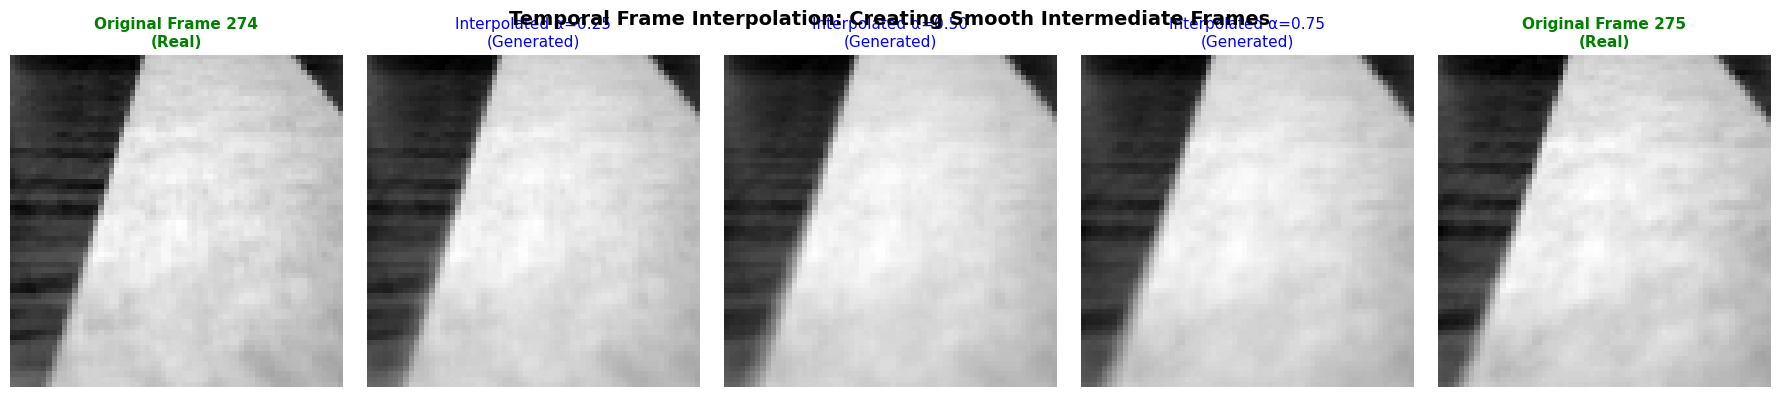


✅ Notice: Interpolated frames show smooth transition between original frames
These represent realistic intermediate vehicle positions during the turn.


In [28]:
# Visualize: Show original frame pair + interpolated frames
# Pick the first consecutive pair for visualization
example_pair = consecutive_pairs[5]  # Use pair 5 as example
idx1, idx2 = example_pair

# Show original frames
frame_t = X_train[idx1]
frame_t1 = X_train[idx2]

# Generate interpolations for this pair
interpolated_sequence = []
for j in range(1, 4):  # 3 intermediate frames
    alpha = j / 4
    interp = (1 - alpha) * frame_t + alpha * frame_t1
    interpolated_sequence.append(interp)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Original frame t
axes[0].imshow(frame_t, cmap='gray')
axes[0].set_title(f'Original Frame {idx1}\n(Real)', fontsize=11, fontweight='bold', color='green')
axes[0].axis('off')

# Interpolated frames
for i, interp_frame in enumerate(interpolated_sequence):
    axes[i+1].imshow(interp_frame, cmap='gray')
    alpha = (i + 1) / 4
    axes[i+1].set_title(f'Interpolated α={alpha:.2f}\n(Generated)', fontsize=11, color='blue')
    axes[i+1].axis('off')

# Original frame t+1
axes[4].imshow(frame_t1, cmap='gray')
axes[4].set_title(f'Original Frame {idx2}\n(Real)', fontsize=11, fontweight='bold', color='green')
axes[4].axis('off')

plt.suptitle('Temporal Frame Interpolation: Creating Smooth Intermediate Frames', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Notice: Interpolated frames show smooth transition between original frames")
print("These represent realistic intermediate vehicle positions during the turn.")

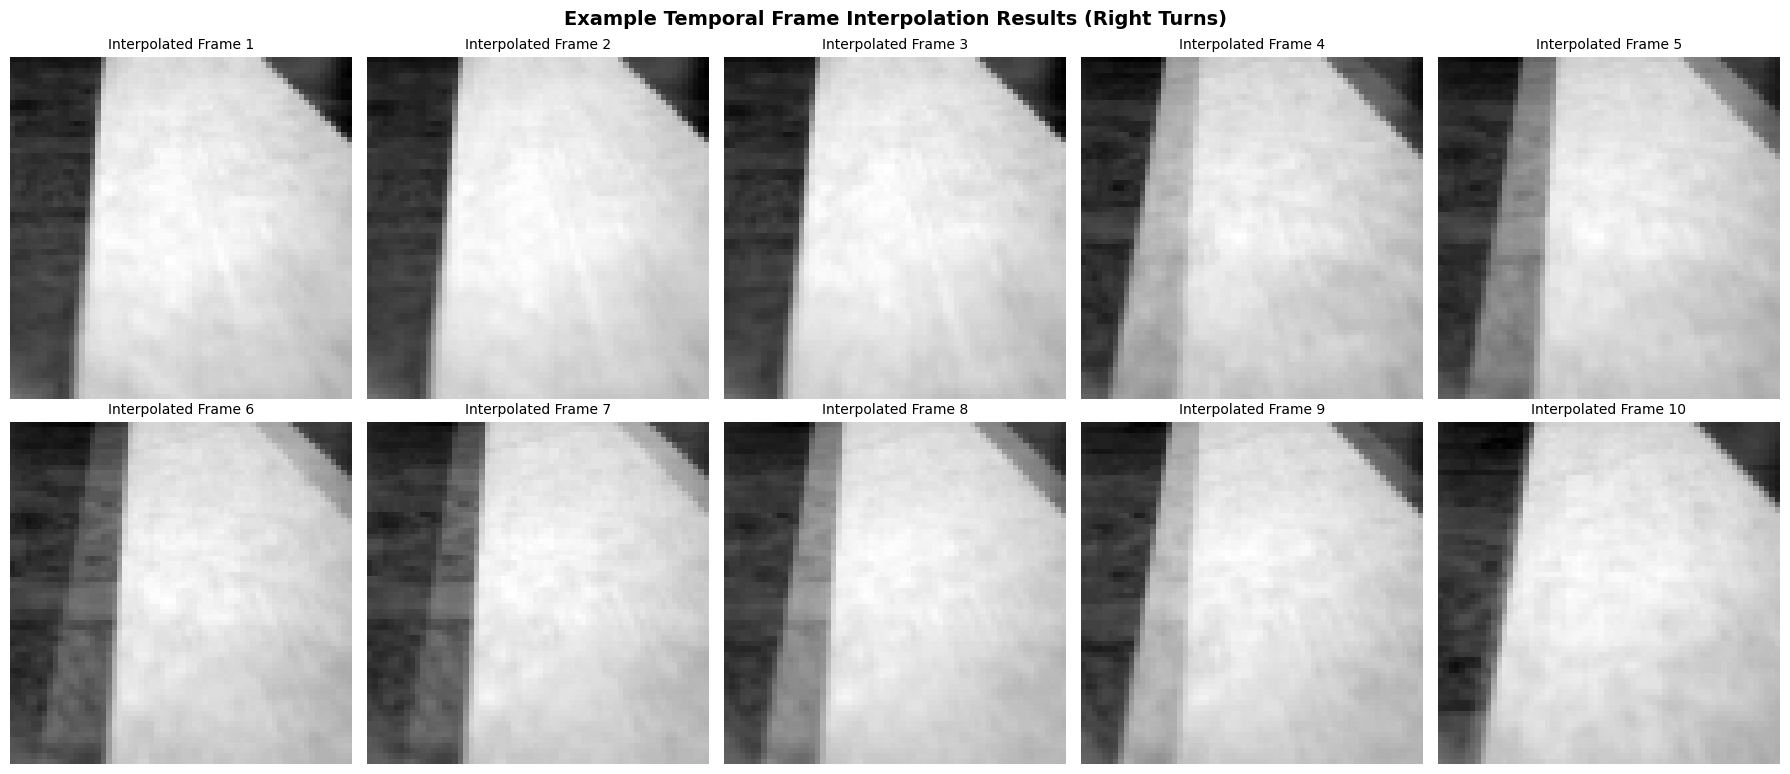

💡 KEY OBSERVATION:
These interpolated frames look REALISTIC - they represent actual vehicle positions.
Compare this to SMOTE which would create blurry nonsense by mixing random frames!


In [29]:
# Show several interpolated frames from different parts of the dataset
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

# Show first 10 interpolated frames
n_show = min(10, len(interpolated_frames))
for i in range(n_show):
    axes[i].imshow(interpolated_frames[i], cmap='gray')
    axes[i].set_title(f'Interpolated Frame {i+1}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Example Temporal Frame Interpolation Results (Right Turns)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 KEY OBSERVATION:")
print("These interpolated frames look REALISTIC - they represent actual vehicle positions.")
print("Compare this to SMOTE which would create blurry nonsense by mixing random frames!")

In [30]:
# Save TFI-balanced dataset
# IMPORTANT: Keep validation and test sets unchanged!
np.savez('../data/splits_temporal_tfi.npz',
         X_train=X_train_tfi, y_train=y_train_tfi,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

print("✅ Saved to: data/splits_temporal_tfi.npz")
print(f"   Training samples: {len(X_train_tfi)} (was {len(X_train)})")
print(f"   Validation samples: {len(X_val)} (unchanged)")
print(f"   Test samples: {len(X_test)} (unchanged)")
print(f"\n   Added {len(X_train_tfi) - len(X_train)} interpolated frames")

✅ Saved to: data/splits_temporal_tfi.npz
   Training samples: 12756 (was 5940)
   Validation samples: 1980 (unchanged)
   Test samples: 1980 (unchanged)

   Added 6816 interpolated frames


## 5. Method 3: Random Oversampling

**How it works**:
- Randomly remove samples from majority class
- Keep all minority samples
- Result: balanced dataset, but smaller

**Advantages**:
- Simple and fast
- No synthetic data created
- Can reduce overfitting on majority class

**Disadvantages**:
- Throws away real data (bad when data is already limited!)
- May lose important majority class patterns
- Likely NOT good for our small dataset

In [31]:
# Apply random oversampling
from imblearn.over_sampling import RandomOverSampler

print("Applying Random Oversampling to minority classes...")
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape(len(X_train), -1)
X_train_over_flat, y_train_over = ros.fit_resample(X_train_flat, y_train)

# Reshape back
X_train_over = X_train_over_flat.reshape(-1, 64, 64)

print("\nBefore Oversampling:")
print(Counter(y_train))
print(f"Total: {len(y_train)} samples")

print("\nAfter Oversampling:")
print(Counter(y_train_over))
print(f"Total: {len(y_train_over)} samples")

print(f"\n✅ All classes now have equal representation ({Counter(y_train_over)[0]} samples each)")
print("Note: Minority classes were duplicated to match majority class size.")

Applying Random Oversampling to minority classes...

Before Oversampling:
Counter({0: 4252, -1: 1033, 1: 655})
Total: 5940 samples

After Oversampling:
Counter({0: 4252, -1: 4252, 1: 4252})
Total: 12756 samples

✅ All classes now have equal representation (4252 samples each)
Note: Minority classes were duplicated to match majority class size.


In [32]:
# Save oversampled dataset
np.savez('../data/splits_temporal_oversample.npz',
         X_train=X_train_over, y_train=y_train_over,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

print("✅ Saved to: data/splits_temporal_oversample.npz")
print(f"   Training samples: {len(X_train_over)} (was {len(X_train)})")

✅ Saved to: data/splits_temporal_oversample.npz
   Training samples: 12756 (was 5940)


## 6. Comparison of All Methods

Let's compare all balancing strategies side-by-side.

In [33]:
# Create comparison table
methods_data = {
    'Original': (y_train, 'No balancing'),
    'TFI': (y_train_tfi, 'Temporal frame interpolation'),
    'Random Over': (y_train_over, 'Duplicate minority samples')
}

import pandas as pd

summary_data = []
for name, (y, desc) in methods_data.items():
    counts = Counter(y)
    summary_data.append({
        'Method': name,
        'Description': desc,
        'Total': len(y),
        'Left': counts.get(-1, 0),
        'Forward': counts.get(0, 0),
        'Right': counts.get(1, 0),
        'Imbalance Ratio': f"{counts.get(0, 1) / counts.get(1, 1):.2f}:1"
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY: Comparison of Class Balancing Methods")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)


SUMMARY: Comparison of Class Balancing Methods
     Method                  Description  Total  Left  Forward  Right Imbalance Ratio
   Original                 No balancing   5940  1033     4252    655          6.49:1
        TFI Temporal frame interpolation  12756  4252     4252   4252          1.00:1
Random Over   Duplicate minority samples  12756  4252     4252   4252          1.00:1


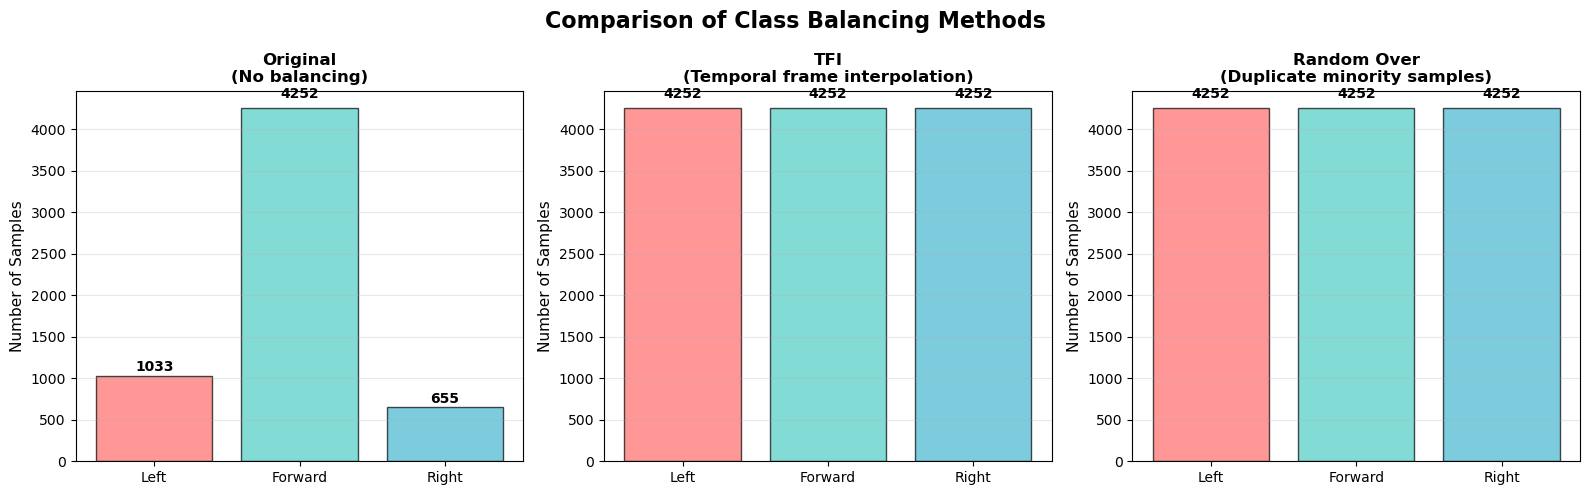

In [34]:
# Visualize all methods side-by-side
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (name, (y, desc)) in enumerate(methods_data.items()):
    ax = axes[i]
    counts = Counter(y)
    
    labels = ['Left', 'Forward', 'Right']
    values = [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Number of Samples', fontsize=11)
    ax.set_title(f'{name}\n({desc})', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for bar, count in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{count}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparison of Class Balancing Methods', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Recommendations

Based on our dataset characteristics and goals:

In [35]:
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

print("\n1. START WITH: Class Weights (Simplest)")
print("   ✅ No dataset modification")
print("   ✅ Fast and effective")
print("   ✅ Works well with neural networks")
print("   → Use: data/class_weights.npy")

print("\n2. IF More Balance Needed: Temporal Frame Interpolation")
print("   ✅ Creates realistic intermediate frames")
print("   ✅ Preserves temporal coherence")
print("   ✅ Perfect for sequential image data")
print("   ⚠️  Increases training time (more samples)")
print("   → Use: data/splits_temporal_tfi.npz")

print("\n3. SIMPLE BACKUP: Random Oversampling")
print("   ✅ Simple duplication of minority samples")
print("   ✅ No fake data, just repeats")
print("   ⚠️  Less sophisticated than TFI")
print("   → Use: data/splits_temporal_oversample.npz")

print("\n❌ AVOID FOR IMAGE DATA:")
print("   • SMOTE - creates blurry unrealistic images")
print("   • Random Undersampling - throws away data (already small dataset)")

print("\n" + "="*80)
print("EVALUATION STRATEGY")
print("="*80)
print("When comparing methods, focus on:")
print("  • Per-class F1 scores (especially Right class)")
print("  • Confusion matrix (are Right turns being predicted?)")
print("  • F1-macro (average of per-class F1, weights all classes equally)")
print("  ⚠️  DON'T rely on overall accuracy alone!")
print("="*80)


RECOMMENDATIONS

1. START WITH: Class Weights (Simplest)
   ✅ No dataset modification
   ✅ Fast and effective
   ✅ Works well with neural networks
   → Use: data/class_weights.npy

2. IF More Balance Needed: Temporal Frame Interpolation
   ✅ Creates realistic intermediate frames
   ✅ Preserves temporal coherence
   ✅ Perfect for sequential image data
   ⚠️  Increases training time (more samples)
   → Use: data/splits_temporal_tfi.npz

3. SIMPLE BACKUP: Random Oversampling
   ✅ Simple duplication of minority samples
   ✅ No fake data, just repeats
   ⚠️  Less sophisticated than TFI
   → Use: data/splits_temporal_oversample.npz

❌ AVOID FOR IMAGE DATA:
   • SMOTE - creates blurry unrealistic images
   • Random Undersampling - throws away data (already small dataset)

EVALUATION STRATEGY
When comparing methods, focus on:
  • Per-class F1 scores (especially Right class)
  • Confusion matrix (are Right turns being predicted?)
  • F1-macro (average of per-class F1, weights all classes equal

## 8. Save Metadata

Save a summary of all methods for easy reference in modeling notebooks.

In [37]:
# Create metadata summary
metadata = {
    'original_distribution': {
        'left': int(train_counts[-1]),
        'forward': int(train_counts[0]),
        'right': int(train_counts[1]),
        'total': int(len(y_train)),
        'imbalance_ratio': float(train_counts[0] / train_counts[1])
    },
    'methods': {
        'class_weights': {
            'description': 'Inverse frequency weights for loss function',
            'file': 'class_weights.npy',
            'changes_dataset': False,
            'train_size': int(len(y_train)),
            'weights': {int(k): float(v) for k, v in class_weights_dict.items()},
            'recommendation': 'Start here - simplest and most effective'
        },
        'temporal_interpolation': {
            'description': 'Temporal frame interpolation between consecutive frames',
            'file': 'splits_temporal_tfi.npz',
            'changes_dataset': True,
            'train_size': int(len(y_train_tfi)),
            'distribution': {int(k): int(v) for k, v in Counter(y_train_tfi).items()},
            'recommendation': 'Best for sequential image data - creates realistic frames'
        },
        'random_oversample': {
            'description': 'Random oversampling (duplication) of minority class',
            'file': 'splits_temporal_oversample.npz',
            'changes_dataset': True,
            'train_size': int(len(y_train_over)),
            'distribution': {int(k): int(v) for k, v in Counter(y_train_over).items()},
            'recommendation': 'Simple backup if TFI not needed'
        }
    },
    'usage_example': {
        'class_weights': 'model.fit(X, y, class_weight=np.load("class_weights.npy").item(), ...)',
        'tfi': 'data = np.load("splits_temporal_tfi.npz"); X_train = data["X_train"]',
        'oversample': 'data = np.load("splits_temporal_oversample.npz"); X_train = data["X_train"]'
    }
}

# Save metadata
with open('../data/imbalance_summary.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadata saved to: data/imbalance_summary.json")
print("\nYou can read this file in modeling notebooks to see details of each method.")

✅ Metadata saved to: data/imbalance_summary.json

You can read this file in modeling notebooks to see details of each method.


## 9. Summary

**Files created**:
1. `data/class_weights.npy` - Class weights for loss function (**recommended start**)
2. `data/splits_temporal_tfi.npz` - Temporal frame interpolation balanced set (**best for images**)
3. `data/splits_temporal_oversample.npz` - Random oversampling (simple backup)
4. `data/imbalance_summary.json` - Metadata about all methods

**Key Innovation**: Temporal Frame Interpolation
- Unlike SMOTE (which creates garbage for images), TFI interpolates between **consecutive frames**
- Creates realistic intermediate vehicle positions
- Preserves temporal coherence of sequential data
- Analogous to video frame rate conversion (24fps → 60fps)

**Next steps**:
1. In baseline models notebook: Compare class weights vs TFI
2. In CNN models notebook: Use best method (likely class weights or TFI)
3. Focus evaluation on per-class F1 scores, not just accuracy

**Expected results**:
- Class weights should improve Right class F1 by 10-15%
- TFI should provide similar or better improvement with more minority samples
- Overall accuracy might drop slightly, but per-class performance improves
- Goal: Balanced performance across all three classes